In [1]:
# Importing the necessary libraries
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fastai.vision.all import *
from sklearn.model_selection import train_test_split  # Added import for train_test_split

In [2]:
# Mounting my Google Drive
from google.colab import drive
drive.mount('/content/drive')

image_folder_path = '/content/drive/MyDrive/Bureau/small'
folders = os.listdir(image_folder_path)

Mounted at /content/drive


In [3]:
# Create separate DataFrames for training and testing
train_df = pd.DataFrame(columns=['file_path', 'label'])
test_df = pd.DataFrame(columns=['file_path', 'label'])

for folder in folders:
    folder_path = os.path.join(image_folder_path, folder)
    files = os.listdir(folder_path)

    # Split files into training and testing
    train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)

    for file in train_files:
        file_path = os.path.join(folder_path, file)
        train_df = train_df.append({'file_path': file_path, 'label': folder}, ignore_index=True)

    for file in test_files:
        file_path = os.path.join(folder_path, file)
        test_df = test_df.append({'file_path': file_path, 'label': folder}, ignore_index=True)

<ipython-input-3-7431106ae096>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'file_path': file_path, 'label': folder}, ignore_index=True)
<ipython-input-3-7431106ae096>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'file_path': file_path, 'label': folder}, ignore_index=True)
<ipython-input-3-7431106ae096>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'file_path': file_path, 'label': folder}, ignore_index=True)
<ipython-input-3-7431106ae096>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'file_path': file_path, '

In [4]:
# Data Augmentation and Preprocessing
target_size = (128, 128)
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Processed images for training
processed_images = []
labels = []

for _, row in train_df.iterrows():
    file_path = row['file_path']

    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    img_array /= 255.0

    for _ in range(5):
        augmented_img = next(data_augmentation.flow(img_array))[0]
        processed_images.append(augmented_img)
        labels.append(row['label'])

In [6]:
# Processed images for testing
test_images = []
test_labels = []

for _, row in test_df.iterrows():
    file_path = row['file_path']

    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    img_array /= 255.0

    test_images.append(img_array)
    test_labels.append(row['label'])

processed_images = np.array(processed_images)
labels = np.array(labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
# Create a DataFrame for image paths and labels for testing
file_paths_test = []
labels_test = []

for _, row in test_df.iterrows():
    file_paths_test.append(row['file_path'])
    labels_test.append(row['label'])

df_test = pd.DataFrame({'file_path': file_paths_test, 'label': labels_test})

In [8]:
# DataBlock and DataLoader for training
train_dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_x=ColReader('file_path', pref='/'),
                         get_y=ColReader('label'),
                         item_tfms=Resize(target_size))
train_dls = train_dblock.dataloaders(train_df)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [9]:
# DataBlock and DataLoader for testing
test_dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_x=ColReader('file_path', pref='/'),
                        get_y=ColReader('label'),
                        item_tfms=Resize(target_size))
test_dls = test_dblock.dataloaders(df_test)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [10]:
# Model Training
learn = cnn_learner(train_dls, resnet34, metrics=accuracy)
learn.fine_tune(epochs=6)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 125MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.153508,1.710047,0.379310,00:13


epoch,train_loss,valid_loss,accuracy,time
0,2.171732,1.375908,0.413793,00:16
1,1.852594,1.120318,0.482759,00:16
2,1.574687,0.932329,0.551724,00:16
3,1.407312,0.768235,0.689655,00:16
4,1.281147,0.709314,0.724138,00:16
5,1.139117,0.725644,0.724138,00:16


In [11]:
# Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                        precision    recall  f1-score   support

                 email       0.80      0.44      0.57         9
                resume       0.46      0.86      0.60         7
scientific_publication       1.00      0.85      0.92        13

              accuracy                           0.72        29
             macro avg       0.75      0.72      0.70        29
          weighted avg       0.81      0.72      0.73        29



/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


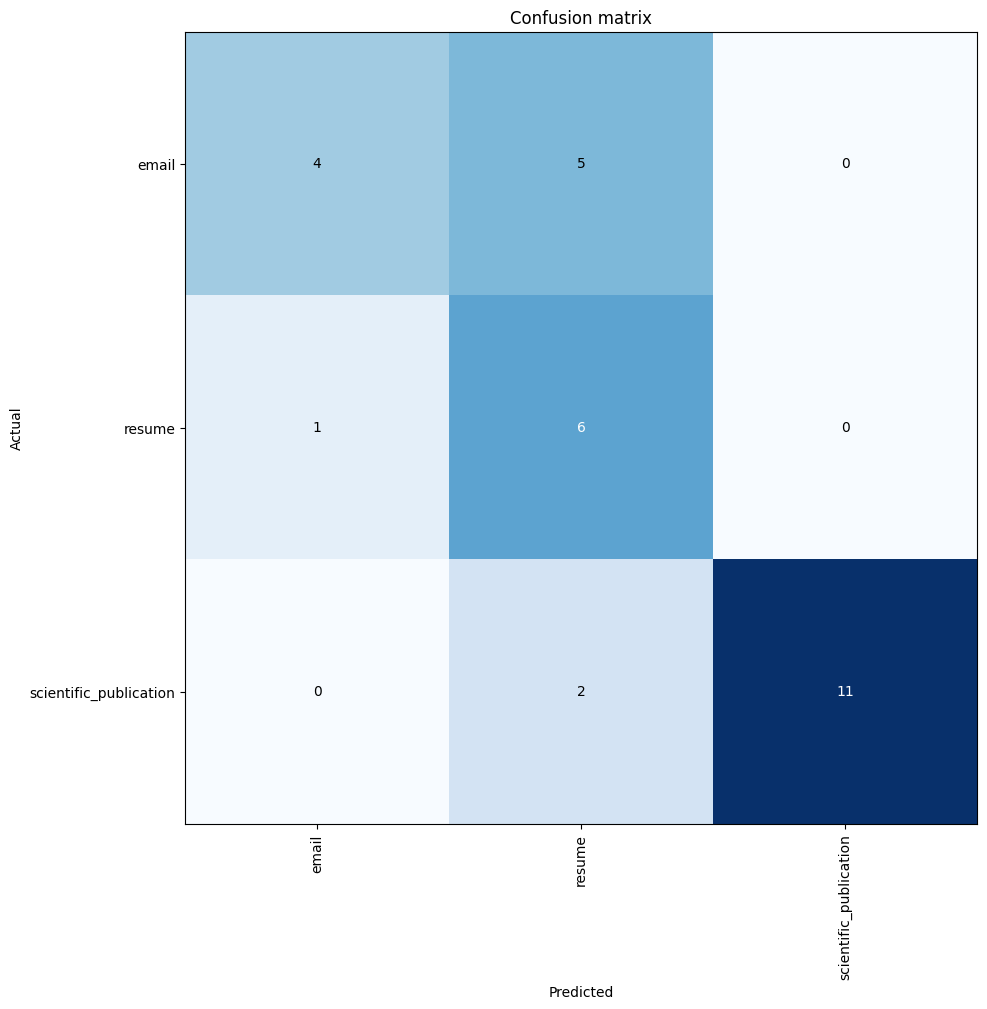

In [12]:
# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(10, 10))

In [13]:
# Print raw confusion matrix values
confusion_matrix = interp.confusion_matrix()
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[ 4  5  0]
 [ 1  6  0]
 [ 0  2 11]]
